In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# Spread rate choice

The goal of the notebook is to explore different ways to compute a spread rate of the COVID-19 for a given country using the cumulative time series of confirmed cases.

This spread rate will then be used to compare the evolution of the COVID-19 in different countries with the position, climate and urbanization of the countries.

## Plotting confirmed cases

Before choosing between different spread rate computation methods, let's plot the cumulative time series of confirmed cases for a few countries to visualize the tendency and the shape of the curves.

In [38]:
data = pd.read_csv('data/data.csv')
data = data.drop(columns=['Latitude', 'Longitude', 'Urban Population', 'Total Population', 'Mortality Rate', 'Mean temperature', 'Climate'])

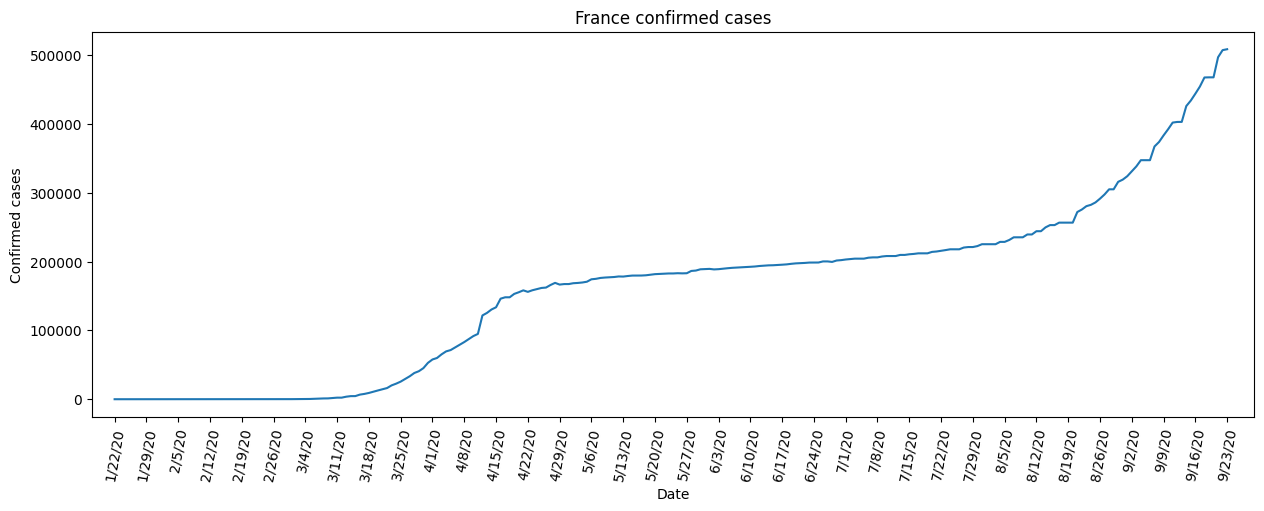

In [39]:
country = 'France'

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = country_data.columns
y = country_data.values[0]

plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.title(f'{country} confirmed cases')
plt.xlim(-5, len(x) + 5)
plt.xlabel('Date')
plt.ylabel('Confirmed cases')
plt.xticks(rotation=80)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
plt.show()

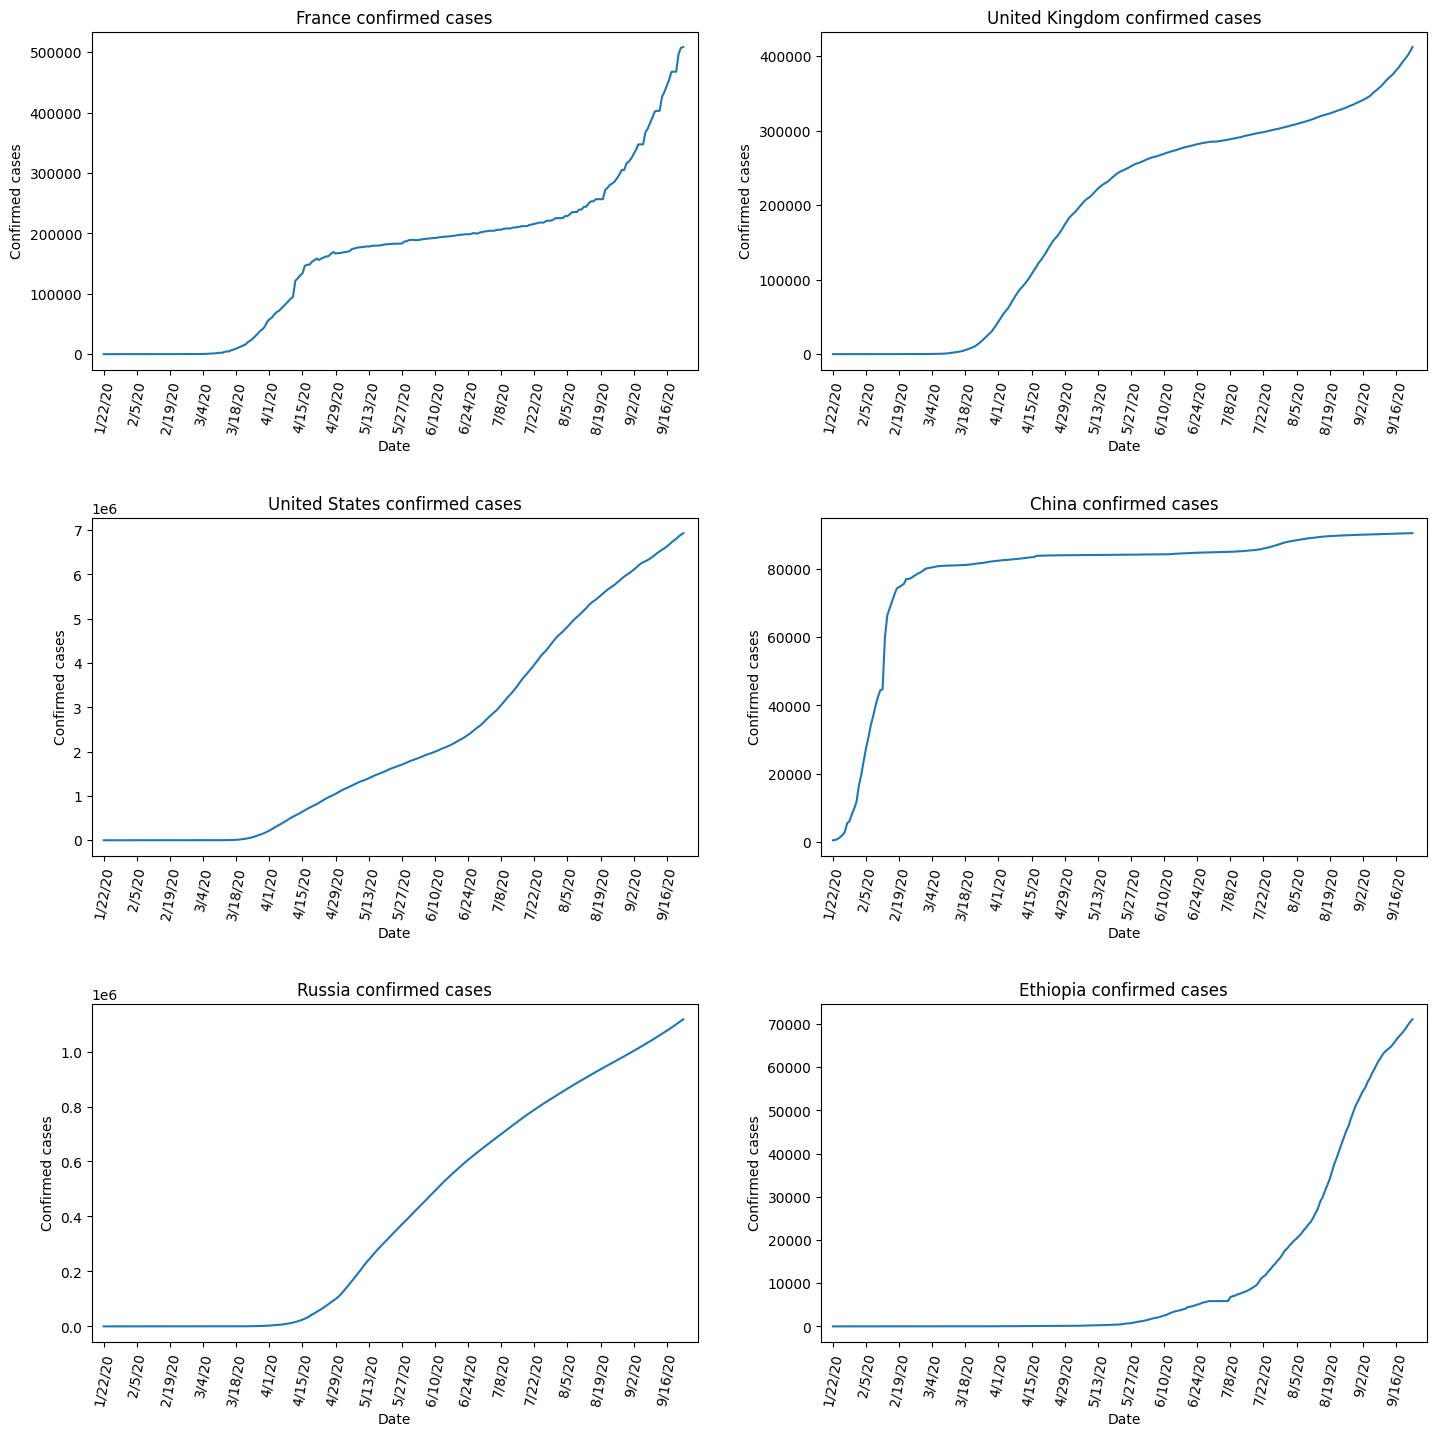

In [40]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))
for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = country_data.columns
    y = country_data.values[0]

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

We can see that the curves have very different shapes, some are linear, some are exponential, some have several phases. This is why it is important to choose a spread rate computation method that is robust to these different shapes.

## Exploring spread rate computation methods

We'll explore the following spread rate computation methods:
- Linear regression
- Exponential regression
- Time to double cases
- Derivative intergration

### Linear regression
In this part, we'll fit a curve of the form $y = ax + b$ to the cumulative time series of confirmed cases. The slope of the linear regression will be the spread rate.

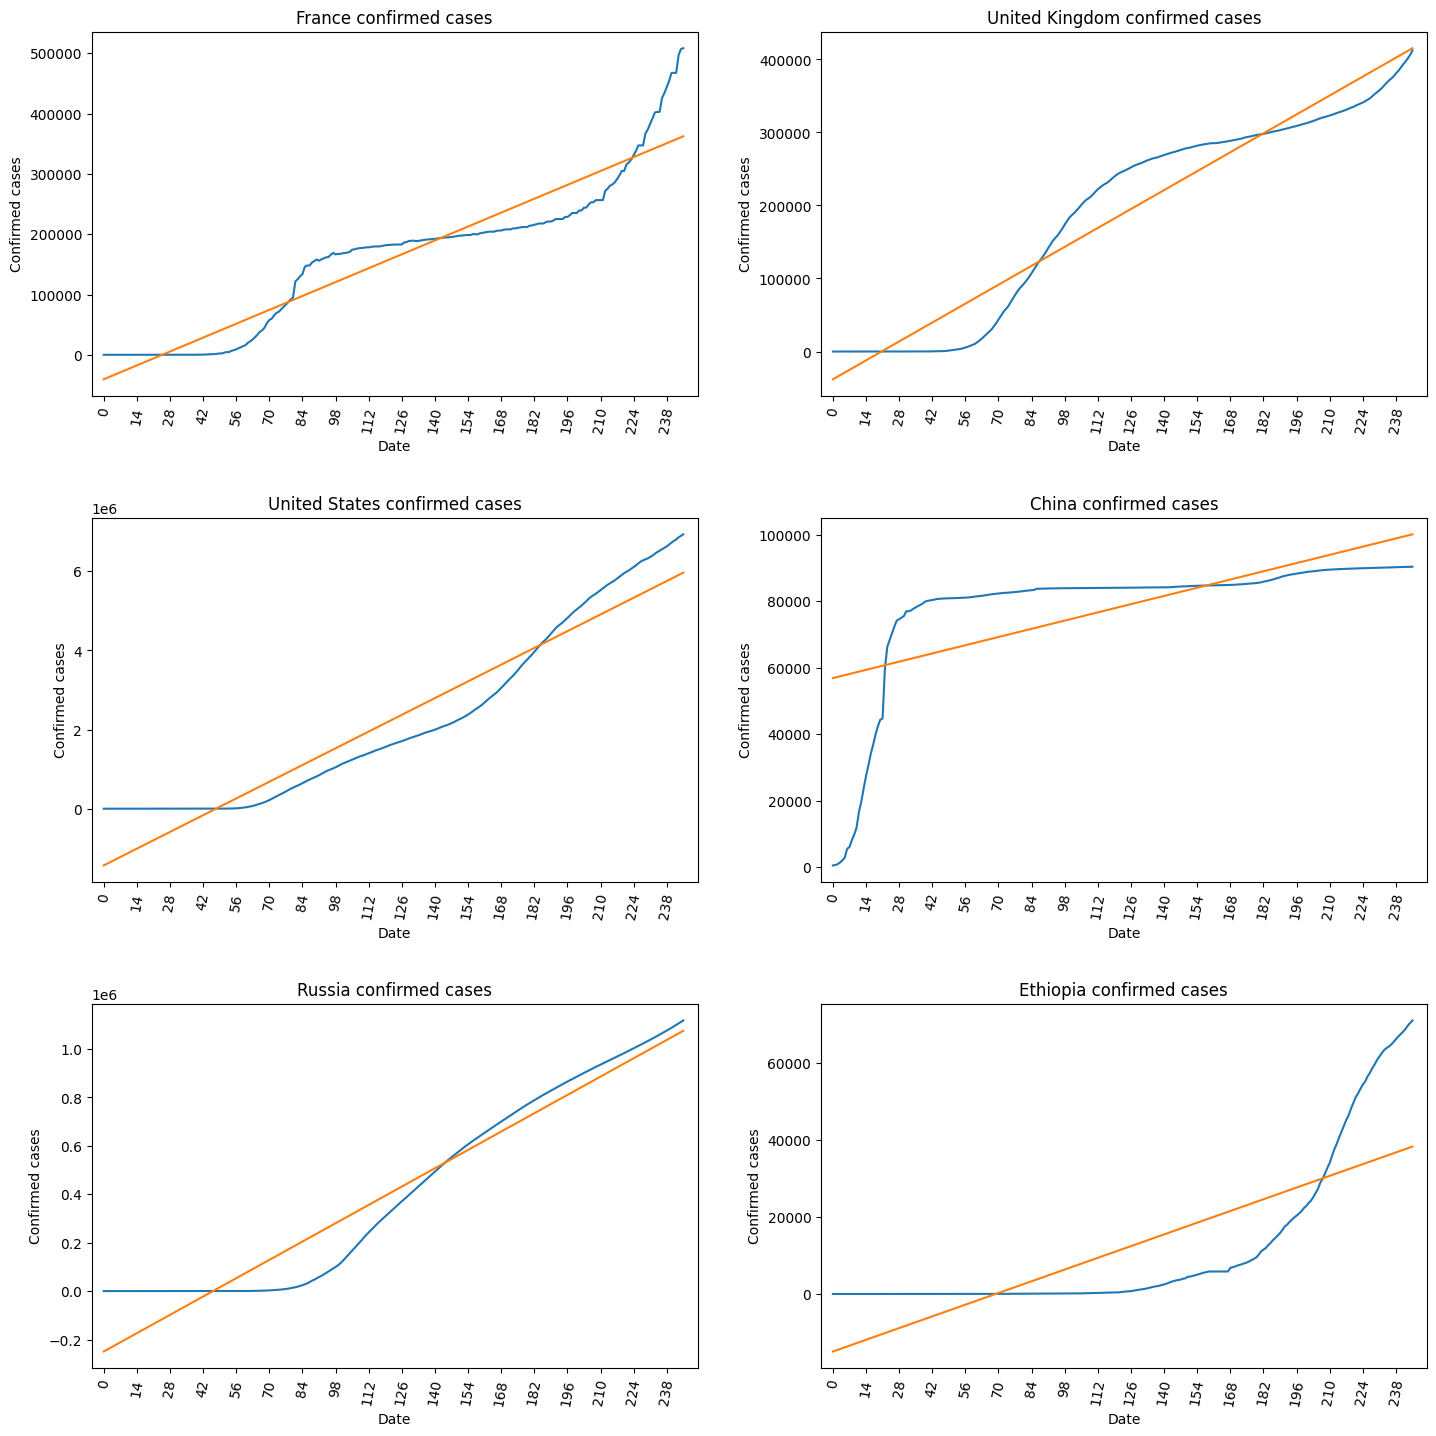

In [41]:
from sklearn.linear_model import LinearRegression


countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = range(len(country_data.columns))
    y = country_data.values[0]

    model = LinearRegression()
    model.fit([[i] for i in x], y)

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].plot(x, model.predict([[i] for i in x]))
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

As we could have expected, the linear regression fits well for countries like Russia and USA that have a linear growth of confirmed cases. However, it is a terrible fit for Ethiopia whose curve looks more like an exponential.

### Exponential regression
In this part, we'll fit a curve of the form $y = \exp(ax + b) + c$ to the cumulative time series of confirmed cases. The slope of the exponential regression will be the spread rate.

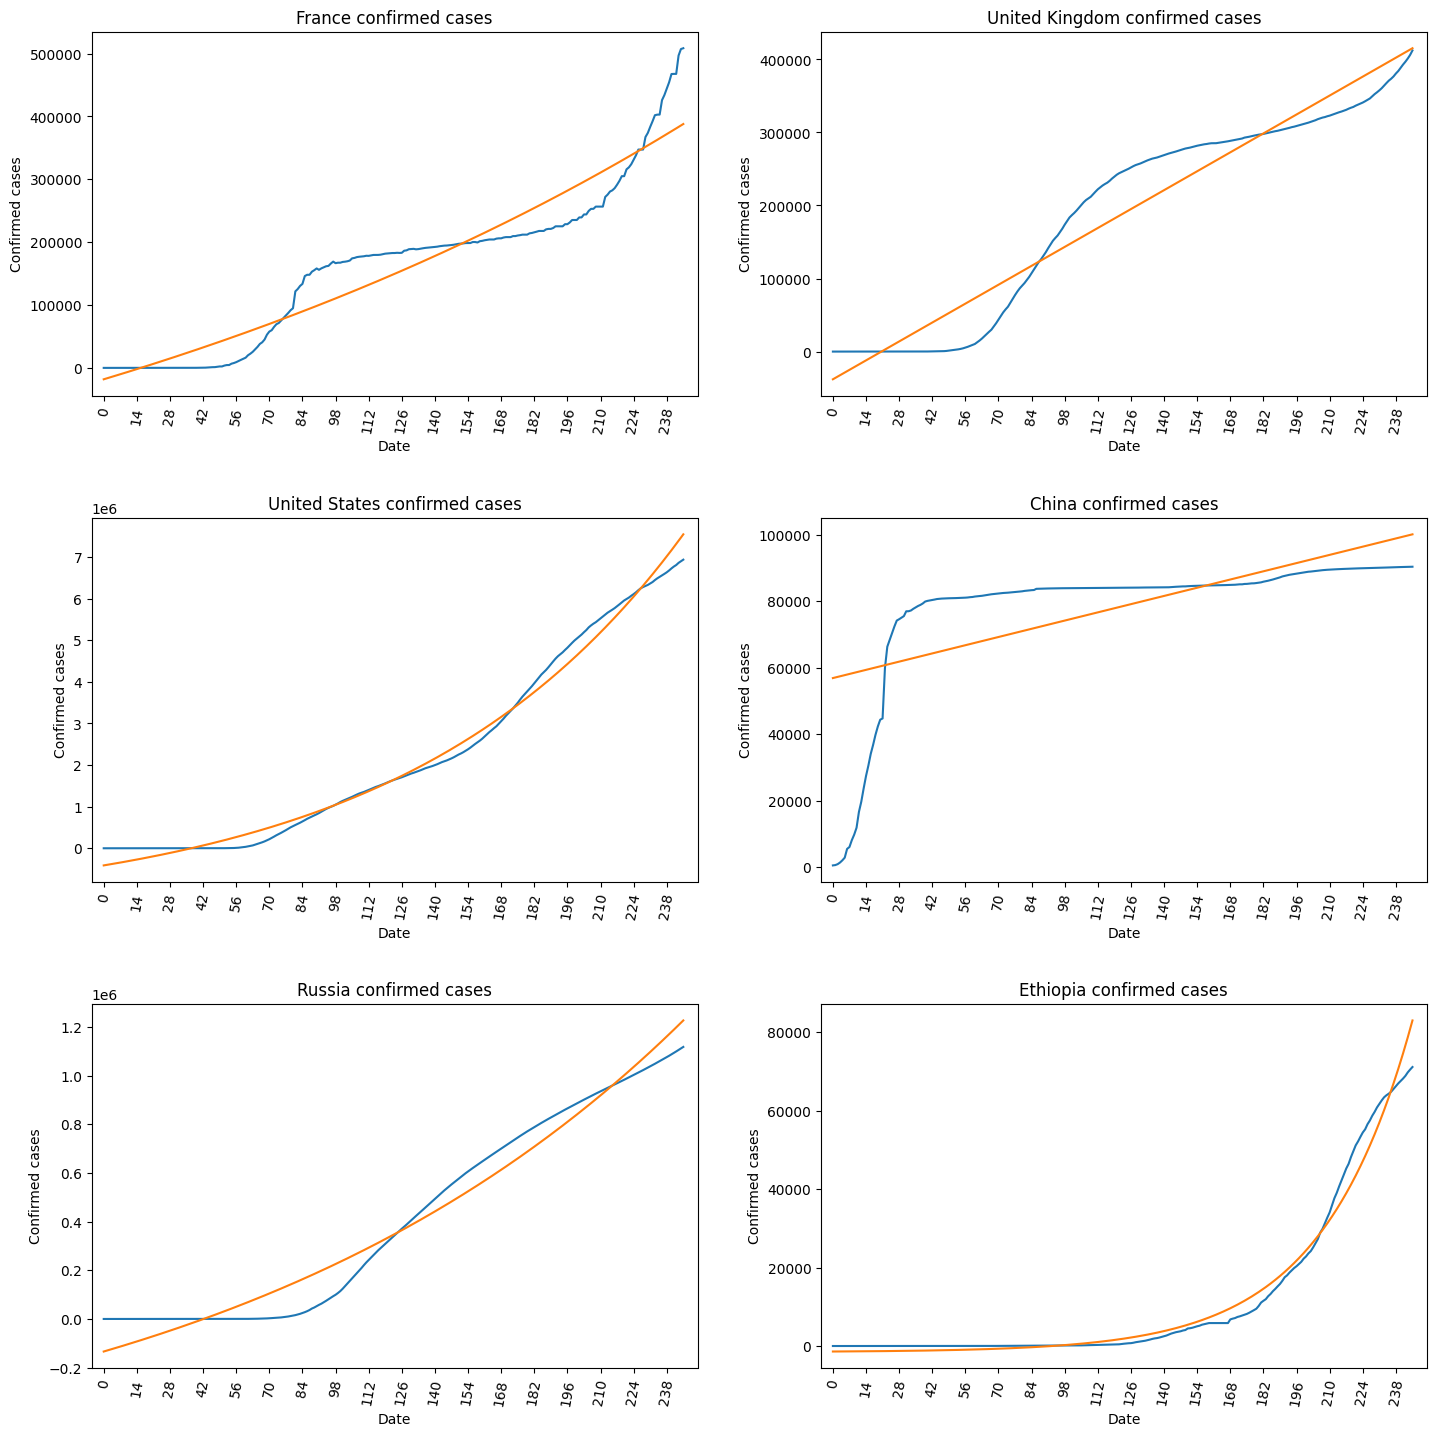

In [52]:
from scipy.optimize import curve_fit
import numpy as np


countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))

def exponential(x, a, b, c):
    return np.exp(a * x + b) + c

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = range(len(country_data.columns))
    y = country_data.values[0]

    popt, _ = curve_fit(exponential, x, y, maxfev=1000000)

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].plot(x, exponential(x, *popt))
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

As we can see, the exponential regression fits very well for Ethiopia and manages to do at least a decent fit for Russia and USA.

### Clipping the time series
From the previous plots, we can see that the cumulative time series of confirmed cases is not always well suited for linear or exponential regression : some countries have curves that alternate between growth and stagnation phases.

The reason for this is probably that a lot of countries have implemented measures to slow down the spread of the COVID-19 and this means that the natural spread rate that we are trying to capture is not visible in every part of the time series.

To solve this problem, we can clip the time series to only keep the part where the derivative of the time series is the highest using the method chosen in the corresponding notebook.

In [53]:
def moving_average(data, window):
    s = pd.Series(data).rolling(window=window, min_periods=1).mean()
    s.fillna(data[:window].mean(), inplace=True)
    return s

def clip_spot_derivative(country_data, start_threshold=0.05, end_threshold=0.7):
    country_data = np.array(country_data).reshape(-1, 1)
    d1 = np.diff(country_data, axis=0)
    max_ = np.argmax(d1)
    start = 0
    end = len(country_data)
    for i in range(max_, 0, -1):
        if d1[i] < start_threshold * max(d1):
            start = i
            break
    for i in range(max_, len(d1)):
        if d1[i] < end_threshold * max(d1):
            end = i
            break
    return start, end

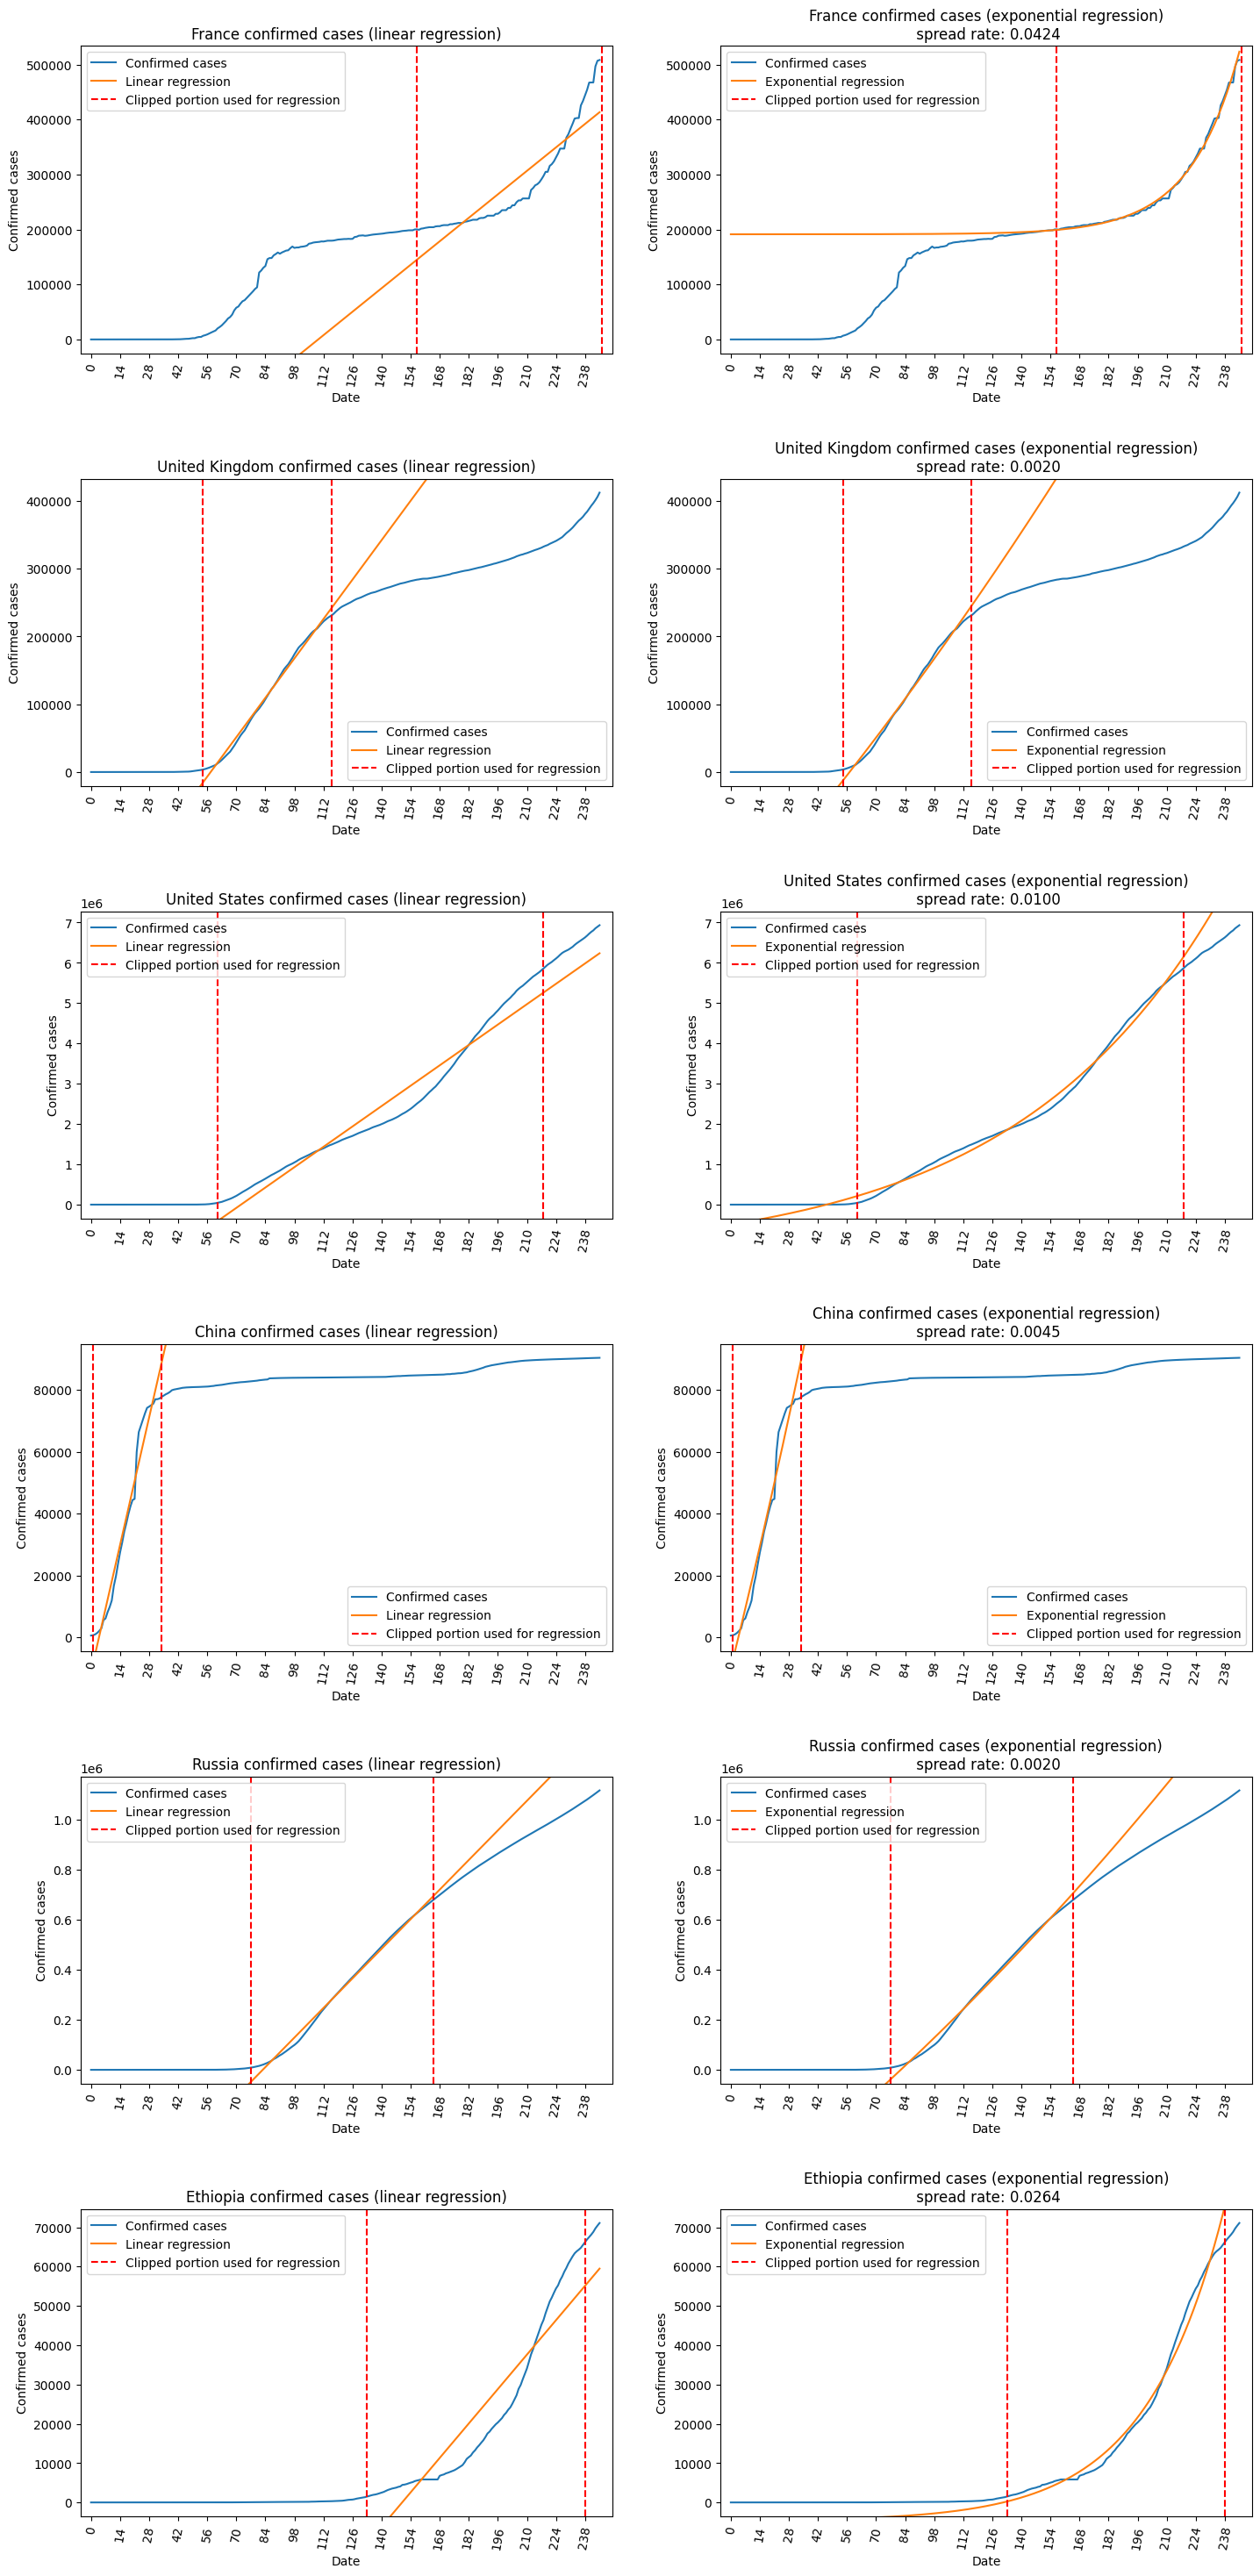

In [54]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(n, 2, figsize=(15, 5 * n))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth)

    model = LinearRegression()
    model.fit([[i] for i in x[start:end]], y[start:end])

    popt, _ = curve_fit(exponential, x[start:end], y[start:end], maxfev=1000000)

    axs[i, 0].plot(x, y)
    axs[i, 0].plot(x, model.predict([[i] for i in x]))
    axs[i, 0].set_title(f'{country} confirmed cases (linear regression)')
    axs[i, 0].set_xlim(-5, len(x) + 5)
    axs[i, 0].set_ylim(-0.05 * max(y), 1.05 * max(y))
    axs[i, 0].set_xlabel('Date')
    axs[i, 0].set_ylabel('Confirmed cases')
    axs[i, 0].tick_params(axis='x', rotation=80)
    axs[i, 0].xaxis.set_major_locator(plt.MultipleLocator(14))

    axs[i, 1].plot(x, y)
    axs[i, 1].plot(x, exponential(x, *popt))
    axs[i, 1].set_title(f'{country} confirmed cases (exponential regression)\n spread rate: {popt[0]:.4f}')
    axs[i, 1].set_xlim(-5, len(x) + 5)
    axs[i, 1].set_ylim(-0.05 * max(y), 1.05 * max(y))
    axs[i, 1].set_xlabel('Date')
    axs[i, 1].set_ylabel('Confirmed cases')
    axs[i, 1].tick_params(axis='x', rotation=80)
    axs[i, 1].xaxis.set_major_locator(plt.MultipleLocator(14))

    # Highlight the portion used for regression
    axs[i, 0].axvline(x=start, color='r', linestyle='--')
    axs[i, 0].axvline(x=end, color='r', linestyle='--')
    axs[i, 1].axvline(x=start, color='r', linestyle='--')
    axs[i, 1].axvline(x=end, color='r', linestyle='--')
    
    # Add legend
    axs[i, 0].legend(['Confirmed cases', 'Linear regression', 'Clipped portion used for regression'])
    axs[i, 1].legend(['Confirmed cases', 'Exponential regression', 'Clipped portion used for regression'])

fig.tight_layout(pad=3.0)
plt.show()

Exponential regression fits well for all countries when the time series is clipped, we must now ensure the chosen method to extract the spread rate will give relevant results given the shape of the curves.